In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sqlite3

# constants
INPUT_FILE_PATH = Path("data/laundry-logger.db")
TABLE_NAME = "accelerometer_readings"
ACCELEROMETER_SAMPLE_RATE_HZ = 104

In [3]:
# read data from sqlite database
readingsDf = None
with sqlite3.connect(INPUT_FILE_PATH) as connection:
  readingsDf = pd.read_sql_query(f"select * from {TABLE_NAME} order by timestamp_ms asc;", connection)

In [4]:
# parse timestamp
readingsDf['received_at'] = pd.to_datetime(readingsDf['received_at'])

# set timestamp as index
readingsDf.set_index('received_at', inplace=True)

# drop id column
readingsDf = readingsDf.drop('id', axis=1)

# calculate magnitude
readingsDf['magnitude'] = np.sqrt(readingsDf['x']**2 + readingsDf['y']**2 + readingsDf['z'] ** 2) # calculate magnitude of acceleration vector

In [5]:
readingsDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4096752 entries, 2024-08-25 10:52:23.482187777-04:00 to 2024-08-25 21:47:12.706728313-04:00
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp_ms  int64  
 1   x             float64
 2   y             float64
 3   z             float64
 4   magnitude     float64
dtypes: float64(4), int64(1)
memory usage: 187.5 MB


In [8]:
firstThousand = readingsDf.iloc[:1040]
meanX = firstThousand['x'].mean()
meanY = firstThousand['y'].mean()
meanZ = firstThousand['z'].mean()

readingsDf['x_zeroed'] = readingsDf['x'] - meanX
readingsDf['y_zeroed'] = readingsDf['y'] - meanY
readingsDf['z_zeroed'] = readingsDf['z'] - meanZ
readingsDf['magnitude_zeroed'] = np.sqrt(readingsDf['x_zeroed'] ** 2 + readingsDf['y_zeroed'] ** 2 + readingsDf['z_zeroed'] ** 2)

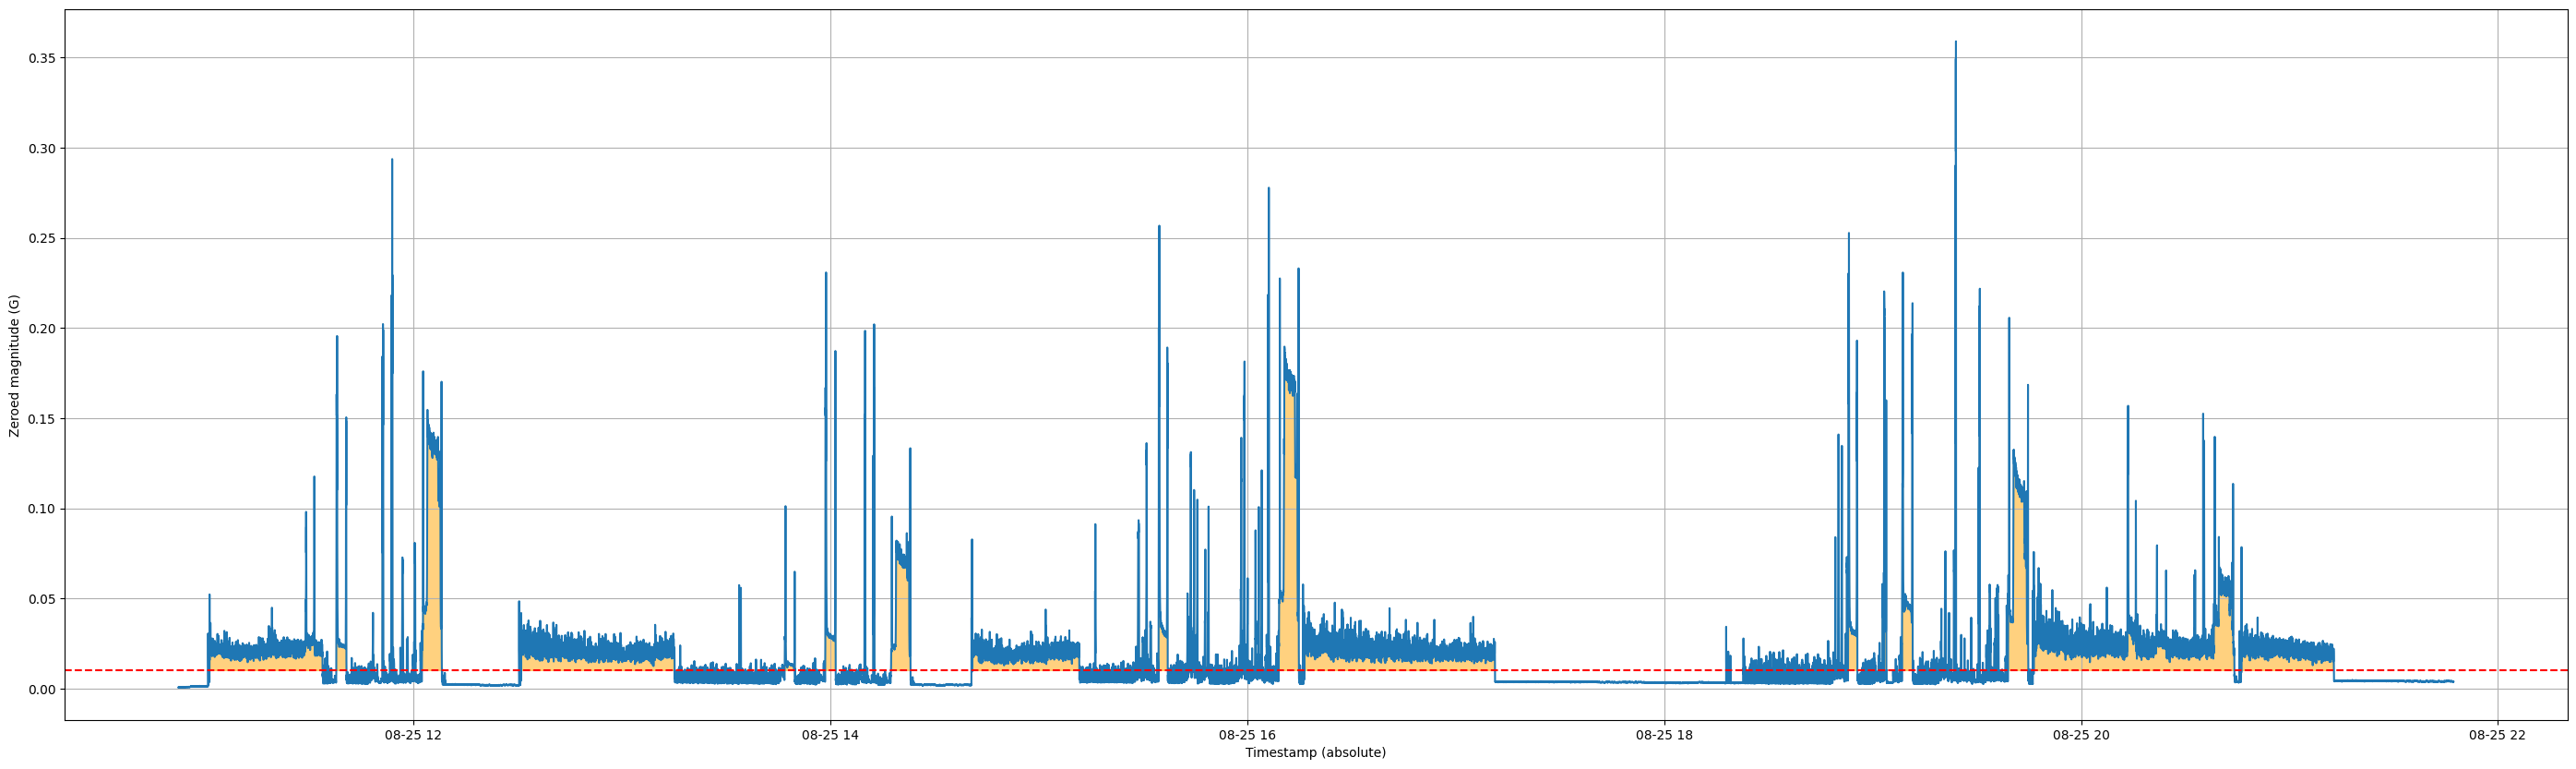

In [13]:
# preliminary plotting
firstMillion = readingsDf.copy()
firstMillion = firstMillion.resample("1s").median()
threshold = 0.01

plt.figure(figsize=(35, 10))

# plot
plt.plot(firstMillion.index, firstMillion['magnitude_zeroed'])

# insert threshold line
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold")

# shade where data exceeds threshold
plt.fill_between(firstMillion.index, threshold, firstMillion['magnitude_zeroed'],
                 where=firstMillion['magnitude_zeroed'] > threshold, color='orange', alpha=0.5,
                 label='Exceeds Threshold')


plt.xlabel('Timestamp (absolute)')
plt.ylabel('Zeroed magnitude (G)')

plt.grid(True)
plt.show()